# Quick tests outside of Test macro

In [1]:
using TestEnv
TestEnv.activate()

"/tmp/jl_lpytfD/Project.toml"

In [2]:
using GalacticDynamics
using Test
using PythonCall
using CairoMakie
using BenchmarkTools
using Profile, ProfileSVG


pyimport("sys")."path".append("")
pyimport("sys")."path".append("../python")
accelerations_py = pyimport("accelerations")
au = pyimport("astropy.units")
gd = pyimport("gala.dynamics")
gp = pyimport("gala.potential")
gu = pyimport("gala.units")
gi = pyimport("gala.integrate")

Python: <module 'gala.integrate' from '/home/mmestre/.conda/envs/cosmos/lib/python3.11/site-packages/gala/integrate/__init__.py'>

#### Setting up initial conditions and potentials in both Gala and GalacticDynamics

In [3]:
Δt = 0.01
n_step = 10000
t₁ = 0.0
t₂ = t₁ + n_step*Δt
@show t₂
t_range = (t₁, t₂)
x₀ = -50.0*SA[1,0,0]
v₀ = 200.0*SA[0,1,0]
m = 10.0^12*𝕦.m  # Msun
a = 20.0*𝕦.l
pot = NFW(m, a)
c = concentration(pot)
f(x) = log(1+x)-x/(1+x)
m_g = m/f(c)
usys = gu.UnitSystem(au.kpc, au.Gyr, au.Msun, au.radian, au.kpc/au.Gyr, au.kpc/au.Gyr^2)
pot_Gala = gp.NFWPotential(Py(adimensional(m_g))*au.Msun, Py(adimensional(a))*au.kpc, units=usys)
w₀ = gd.PhaseSpacePosition(pos=Py(x₀)*au.kpc, vel=Py(v₀)*au.kpc/au.Gyr)

t₂ = 100.0


Python: <PhaseSpacePosition cartesian, dim=3, shape=()>

### Orbit plot with Gala and GalacticDynamics


𝕤.ode = Vern9(; stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true,)
sol_gala.t[-1] = <py Quantity 100. Gyr>
sol.t[end] = 100.0
findmax(sol_diff) = (2.1460130350536843e-6, 9766)


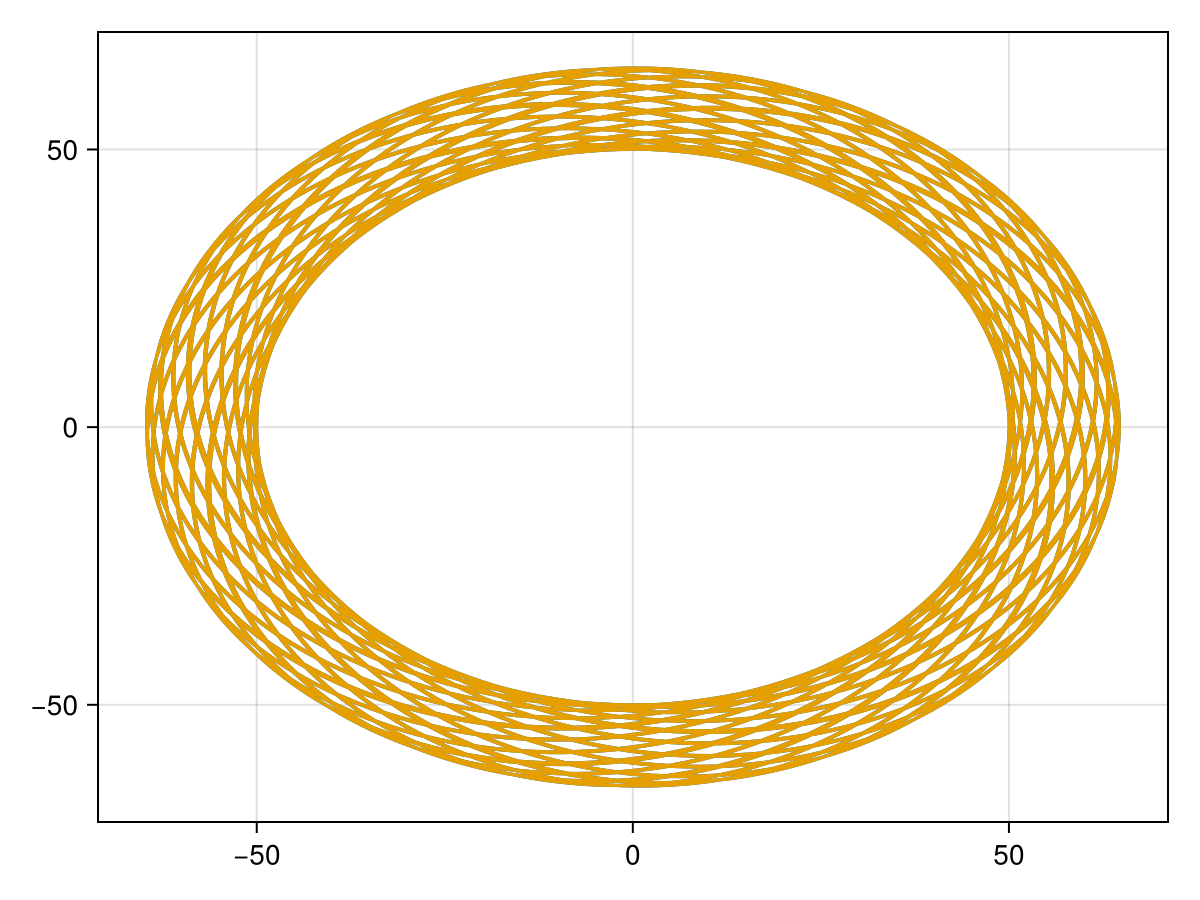

In [178]:
sol_gala = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂+1.e-7)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-12)))
sol = evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(;reltol=5.0e-12, saveat=Δt))

@show 𝕤.ode
@show sol_gala.t[-1]
@show sol.t[end]
orb_gala_x = pyconvert(Vector{Float64}, sol_gala.x)
orb_gala_y = pyconvert(Vector{Float64}, sol_gala.y)
orb_x = sol.x[1,:]
orb_y = sol.x[2,:]
sol_diff = abs.(orb_gala_x-orb_x)
@show findmax(sol_diff)
lines(orb_gala_x,orb_gala_y)
lines!(orb_x,orb_y)
current_figure()



### Precision

#### Precision test between Gala and GalacticDynamics
##### For the NFW
Adding `atol=0.5e-16` in both Gala and GalacticDynamics improves the precision by two orders of magnitude, only when `rtol` is already very small (`< 10^{-16}`).

In [179]:
orb₁ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=t₂*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-6)))
orb₂ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-11)))
orb₃ = pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                Integrator=gi.DOPRI853Integrator,
                                Integrator_kwargs=Py(Dict("rtol"=>5.0e-20, "atol"=>0.5e-20)))
orb₄ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Δt))
orb₅ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₆ = evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))
orb₇ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-6, saveat=Δt))
orb₈ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-11,saveat=Δt))
orb₉ = evolve(pot, x₀, v₀, t_range, Vern9(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16,
saveat=Δt))
@show orb₁.x[-1]  orb₂.x[-1]  orb₃.x[-1]
@show orb₄.x[1,end]  orb₅.x[1,end]  orb₆.x[1,end]
@show orb₇.x[1,end]  orb₈.x[1,end]  orb₉.x[1,end]
@show orb₄.x[1,end]-orb₁.x[-1].value  orb₅.x[1,end]-orb₂.x[-1].value  orb₆.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₁.x[-1].value  orb₈.x[1,end]-orb₂.x[-1].value  orb₉.x[1,end]-orb₃.x[-1].value
@show orb₇.x[1,end]-orb₄.x[1,end]  orb₈.x[1,end]-orb₅.x[1,end]  orb₉.x[1,end]-orb₆.x[1,end];

orb₁.x[-1] = <py Quantity -50.51022859 kpc>
orb₂.x[-1] = <py Quantity -50.51022859 kpc>
orb₃.x[-1] = <py Quantity -50.51022859 kpc>
orb₄.x[1, end] = -51.42769406271274
orb₅.x[1, end] = -51.41116708230581
orb₆.x[1, end] = -51.41116702004823
orb₇.x[1, end] = -51.43333057944279
orb₈.x[1, end] = -51.41116713896092
orb₉.x[1, end] = -51.41116702000843
orb₄.x[1, end] - (orb₁.x[-1]).value = <py -0.9174654721435829>
orb₅.x[1, end] - (orb₂.x[-1]).value = <py -0.9009384917366532>
orb₆.x[1, end] - (orb₃.x[-1]).value = <py -0.9009384295096581>
orb₇.x[1, end] - (orb₁.x[-1]).value = <py -0.9231019888736327>
orb₈.x[1, end] - (orb₂.x[-1]).value = <py -0.900938548391764>
orb₉.x[1, end] - (orb₃.x[-1]).value = <py -0.9009384294698535>
orb₇.x[1, end] - orb₄.x[1, end] = -0.005636516730049834
orb₈.x[1, end] - orb₅.x[1, end] = -5.665511082497687e-8
orb₉.x[1, end] - orb₆.x[1, end] = 3.980460405728081e-11


#### Precision test between Gala and GalacticDynamics
##### For the MN disk

In [180]:
gp = pyimport("gala.potential")
gd= pyimport("gala.dynamics")
gu = pyimport("gala.units")
pot_mn = gp.MiyamotoNagaiPotential(m=2.5E11*au.Msun, a=6.5*au.kpc,b=0.26*au.kpc, units=gu.galactic)
w0 = gd.PhaseSpacePosition(pos=Py([11., 0., 0.2])*au.kpc, vel=Py([0., 200, 100])*au.km/au.s)
orb₁ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator)
orb₂ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
orb₃_c = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator,  cython_if_possible=true, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₃ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.DOPRI853Integrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-5)))
orb₄ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator)
orb₅ = pot_mn.integrate_orbit(w0, dt=1., n_steps=1000, Integrator=gi.LeapfrogIntegrator, Integrator_kwargs=Py(Dict("rtol"=>5.0e-15)))
@show orb₁.x[-1] orb₂.x[-1] orb₃_c.x[-1] orb₃.x[-1]  orb₄.x[-1] orb₅.x[-1];

orb₁.x[-1] = <py Quantity 6.76980261 kpc>
orb₂.x[-1] = <py Quantity 6.76980261 kpc>
orb₃_c.x[-1] = <py Quantity 6.76980252 kpc>
orb₃.x[-1] = <py Quantity 6.76980252 kpc>
orb₄.x[-1] = <py Quantity 6.74183738 kpc>
orb₅.x[-1] = <py Quantity 6.74183738 kpc>


### Speed tests

#### BenchmarkTools only tests memory consumption on the Julia side. The time is real as long as C is not working asynchronously.

In [181]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))

BenchmarkTools.Trial: 261 samples with 1 evaluation.
 Range (min … max):  18.234 ms … 27.463 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.869 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.180 ms ±  1.125 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

     ▅▇█▇▃ ▁▁                                                  
  ▂▄▇████████▄▄▄▅▃▃▃▂▃▂▃▁▁▁▁▁▁▁▃▃▂▂▁▁▁▁▂▂▁▂▁▁▁▁▂▁▁▃▁▁▁▁▁▁▁▁▁▂ ▃
  18.2 ms         Histogram: frequency by time        23.9 ms <

 Memory estimate: 3.02 KiB, allocs estimate: 141.

In [182]:
@benchmark pot_Gala.integrate_orbit(w₀, dt=Δt*au.Gyr, t1=t₁, t2=(t₂)*au.Gyr,
                                    Integrator=gi.DOPRI853Integrator,
                                    cython_if_possible=true,
                                    Integrator_kwargs=Py(Dict("rtol"=>5.0e-16, "atol"=>0.5e-16)))


BenchmarkTools.Trial: 262 samples with 1 evaluation.
 Range (min … max):  18.252 ms … 43.710 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     18.947 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   19.063 ms ±  1.556 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                  ▁ ▂ ▄▁▁▁▆ ▇▁▄█▁▁    ▁  ▁▁                    
  ▃▁▁▁▁▃▅▁▃▃▅▆▁▅▅▅█▅█▅█████▆██████▆▅▅▄█▃▇██▅▄▆▇▄▄▃▃▃▃▁▁▃▃▁▁▁▃ ▄
  18.3 ms         Histogram: frequency by time        19.8 ms <

 Memory estimate: 3.26 KiB, allocs estimate: 144.

In [187]:
@benchmark evolve(pot, x₀, v₀, t_range, Vern7(); options=ntSolverOptions(;reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))

BenchmarkTools.Trial: 339 samples with 1 evaluation.
 Range (min … max):  13.523 ms … 22.993 ms  ┊ GC (min … max): 0.00% … 37.89%
 Time  (median):     14.357 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.748 ms ±  1.210 ms  ┊ GC (mean ± σ):  0.51% ±  2.81%

      ▄▆█▁                                                     
  ▃▄▄██████▅▇▇▅▆▆▄▄▄▃▃▂▃▃▂▂▃▁▁▁▂▃▂▁▂▁▁▂▁▁▂▁▁▂▂▁▁▂▁▁▁▁▂▁▁▁▁▁▂▃ ▃
  13.5 ms         Histogram: frequency by time        20.4 ms <

 Memory estimate: 2.77 MiB, allocs estimate: 148.

In [195]:
@benchmark evolve(pot, x₀, v₀, (t₁,t₂/10), DP8(); options=ntSolverOptions(;reltol=5.0e-16, saveat=Δt))

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  339.540 μs …   7.443 ms  ┊ GC (min … max): 0.00% … 87.05%
 Time  (median):     368.606 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   397.793 μs ± 197.694 μs  ┊ GC (mean ± σ):  3.10% ±  6.06%

    █▇▄                                                          
  ▃▅███▇▆▆▅▄▅▅▅▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  340 μs           Histogram: frequency by time          646 μs <

 Memory estimate: 283.80 KiB, allocs estimate: 144.

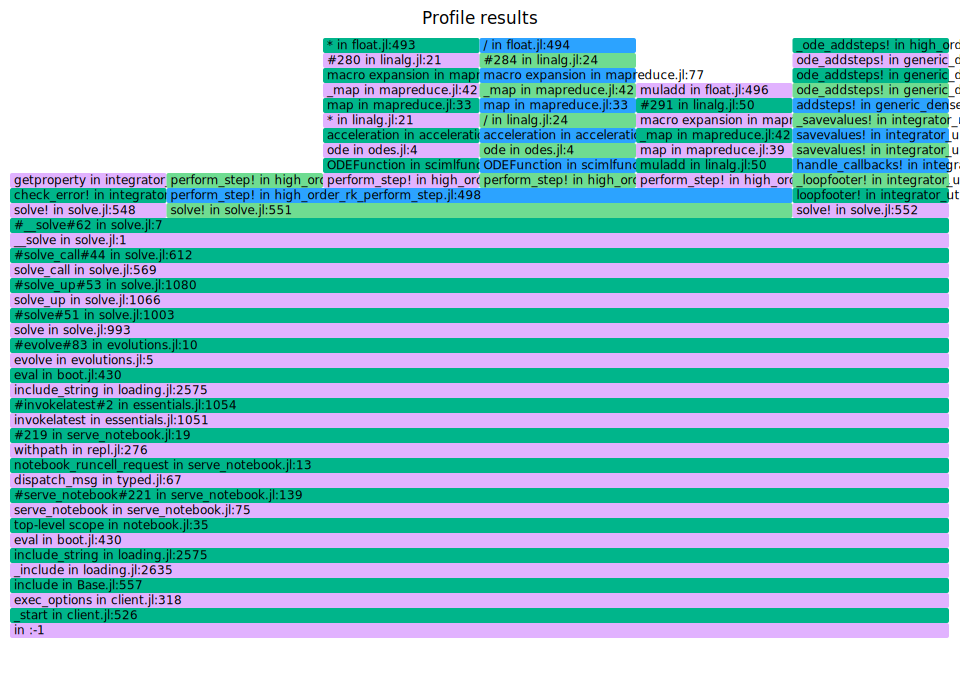

In [19]:
ProfileSVG.@profview evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))

In [ ]:
@profview evolve(pot, x₀, v₀, t_range, DP8(); options=ntSolverOptions(; reltol=5.0e-16, abstol=0.5e-16, saveat=Δt))